## Imports

In [1]:
import kagglehub

import pandasql as ps
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, hour, date_format

/home/arthur/venv/trabalho-pyspark-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregando Dados

In [2]:
spark = SparkSession.builder.appName('Exemplo2').config("spark.executor.cores", "4").getOrCreate()

25/01/23 07:48:46 WARN Utils: Your hostname, notebook resolves to a loopback address: 127.0.1.1; using 192.168.18.27 instead (on interface wlp2s0)
25/01/23 07:48:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/23 07:48:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Download latest version
# path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
# print("Path to dataset files:", path)

df = spark.read.csv('/home/arthur/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv', header=True, inferSchema=True)

In [4]:
df.show()

25/01/23 07:50:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

## Descrição dos Dados

In [5]:
print(f"Número de Linhas: {df.count()}")
print(f"Número de Colunas: {len(df.columns)}")

Número de Linhas: 7728394
Número de Colunas: 46


### Identificação e Origem
ID: Identificador único para cada registro no dataset.

Source: Fonte ou sistema de onde os dados foram obtidos.

### Detalhes do Incidente
Severity: Nível de gravidade do incidente, geralmente representado por um número inteiro.

Start_Time: Data e hora de início do incidente.

End_Time: Data e hora de término do incidente.

Description: Descrição textual do incidente.

### Localização Geográfica
Start_Lat: Latitude do ponto inicial do incidente.

Start_Lng: Longitude do ponto inicial do incidente.

End_Lat: Latitude do ponto final do incidente.

End_Lng: Longitude do ponto final do incidente.

Distance(mi): Distância total do incidente em milhas.

Street: Nome da rua onde o incidente ocorreu.

City: Cidade onde o incidente ocorreu.

County: Condado onde o incidente ocorreu.

State: Estado onde o incidente ocorreu.

Zipcode: Código postal da área onde o incidente ocorreu.

Country: País onde o incidente ocorreu.

Timezone: Fuso horário da localização do incidente.

Airport_Code: Código do aeroporto mais próximo ao local do incidente.


### Condições Climáticas
Weather_Timestamp: Data e hora da coleta das condições meteorológicas.

Temperature(F): Temperatura em graus Fahrenheit no momento do incidente.

Wind_Chill(F): Sensação térmica em graus Fahrenheit.

Humidity(%): Umidade relativa do ar em porcentagem.

Pressure(in): Pressão atmosférica em polegadas de mercúrio.

Visibility(mi): Visibilidade em milhas no momento do incidente.

Wind_Direction: Direção do vento.

Wind_Speed(mph): Velocidade do vento em milhas por hora.

Precipitation(in): Precipitação em polegadas.

Weather_Condition: Condição meteorológica no momento do incidente (e.g., chuva, neve, nublado).


### Condições da Via
Amenity: Indica se havia uma amenidade próxima (True/False).

Bump: Indica se havia um quebra-molas (True/False).

Crossing: Indica se havia uma travessia de pedestres (True/False).

Give_Way: Indica se havia uma sinalização de "Dê a preferência" (True/False).

Junction: Indica se o incidente ocorreu em uma junção (True/False).

No_Exit: Indica se a área era um beco sem saída (True/False).

Railway: Indica se havia uma ferrovia próxima (True/False).

Roundabout: Indica se havia uma rotatória próxima (True/False).

Station: Indica se havia uma estação próxima (True/False).

Stop: Indica se havia uma placa de parada próxima (True/False).

Traffic_Calming: Indica se havia medidas de acalmia de tráfego (True/False).

Traffic_Signal: Indica se havia semáforos próximos (True/False).

Turning_Loop: Indica se havia um retorno próximo (True/False).


### Condições de Luminosidade

Sunrise_Sunset: Indica se o incidente ocorreu durante o nascer ou pôr do sol.

Civil_Twilight: Período de crepúsculo civil (luz solar indireta).

Nautical_Twilight: Período de crepúsculo náutico (horizonte visível ao mar).

Astronomical_Twilight: Período de crepúsculo astronômico (pouca ou nenhuma luz solar).


## Tratamento dos Dados

#### Check NAs

In [6]:
df_nulls = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

df_nulls_pandas = df_nulls.toPandas()

df_nulls_pandas_perc = 100* (df_nulls_pandas.T / df.count())

df_nulls_pandas_perc.map('{:.2f}%'.format)

,0
ID,0.00%
Source,0.00%
Severity,0.00%
Start_Time,0.00%
End_Time,0.00%
Start_Lat,0.00%
Start_Lng,0.00%
End_Lat,44.03%
End_Lng,44.03%
Distance(mi),0.00%


### Drop NAs

In [7]:
columns = df.columns
cols_to_remove = ['End_Lat','End_Lng', 'Wind_Chill(F)', 'Precipitation(in)']
cols_to_drop = [c for c in columns if c not in cols_to_remove ]

df_cleaned_subset = df.dropna(subset=cols_to_drop)

df_cleaned_subset.show()

+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

In [8]:
print(f"Número de Linhas: {df_cleaned_subset.count()}")
print(f"Número de Colunas: {len(df_cleaned_subset.columns)}")

Número de Linhas: 7051556
Número de Colunas: 46


## Feature Engineering

In [75]:
# Extrai o dia da semana
df_cleaned_subset = df_cleaned_subset.withColumn("day_of_week", date_format(col("Start_Time"), "F"))

# Extrai a hora do dia
df_cleaned_subset = df_cleaned_subset.withColumn("hour_of_day", hour(col("Start_Time")))

## Análise Exploratória

In [76]:
sampled_df = df_cleaned_subset.sample(withReplacement=False, fraction=0.01)

sampled_df.show()

+------+-------+--------+-------------------+-------------------+------------------+-------------------+-------+-------+------------+--------------------+-----------------+------------+------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|    ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|           Street|        City|      County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipita

In [78]:
data_in_pandas = sampled_df.toPandas()

In [11]:
def barplot(data, query, hue=False):

    data = ps.sqldf(query, locals())

    if hue:
        sns.barplot(data=data, x = data[data.columns[0]], y = data[data.columns[-1]], hue = data[data.columns[1]])
    else:
        sns.barplot(data=data, x = data[data.columns[0]], y = data[data.columns[-1]])

def histplot(data, query, hue=False, bins = None, rotation = None, figsize = None):

    data = ps.sqldf(query, locals())

    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotation)

    if hue:
        return sns.histplot(data=data, x = data[data.columns[0]], hue = data[data.columns[1]], multiple = 'fill', bins = bins)
    else:
        return sns.histplot(data=data, x = data[data.columns[0]], bins = bins)
    
def plot_matrix(data, columns_features, n_rows, n_cols, plot, plot_kwargs = {}, loop_feature = None, figsize = (15,15), label = True):

    grid = gridspec.GridSpec(n_rows, n_cols)

    plt.figure(figsize=figsize)

    for r in range(0, n_rows):
        for c in range(0, n_cols ):
            if (c + r*n_cols) >= len(columns_features):
                break
            else:
                feature = columns_features[ (c + r*n_cols) ]

                if loop_feature:
                    plot_kwargs[loop_feature] = feature
                    
                plt.subplot(grid[r, c])
                plt.title(f'{feature}')
                g = plot(data = data, **plot_kwargs)

                if label:
                    for i in g.containers:
                        g.bar_label(i, color = 'black',label_type='edge')
                    else:
                        pass
            
    plt.tight_layout()

### Análise Univariada

#### Variáveis Numéricas

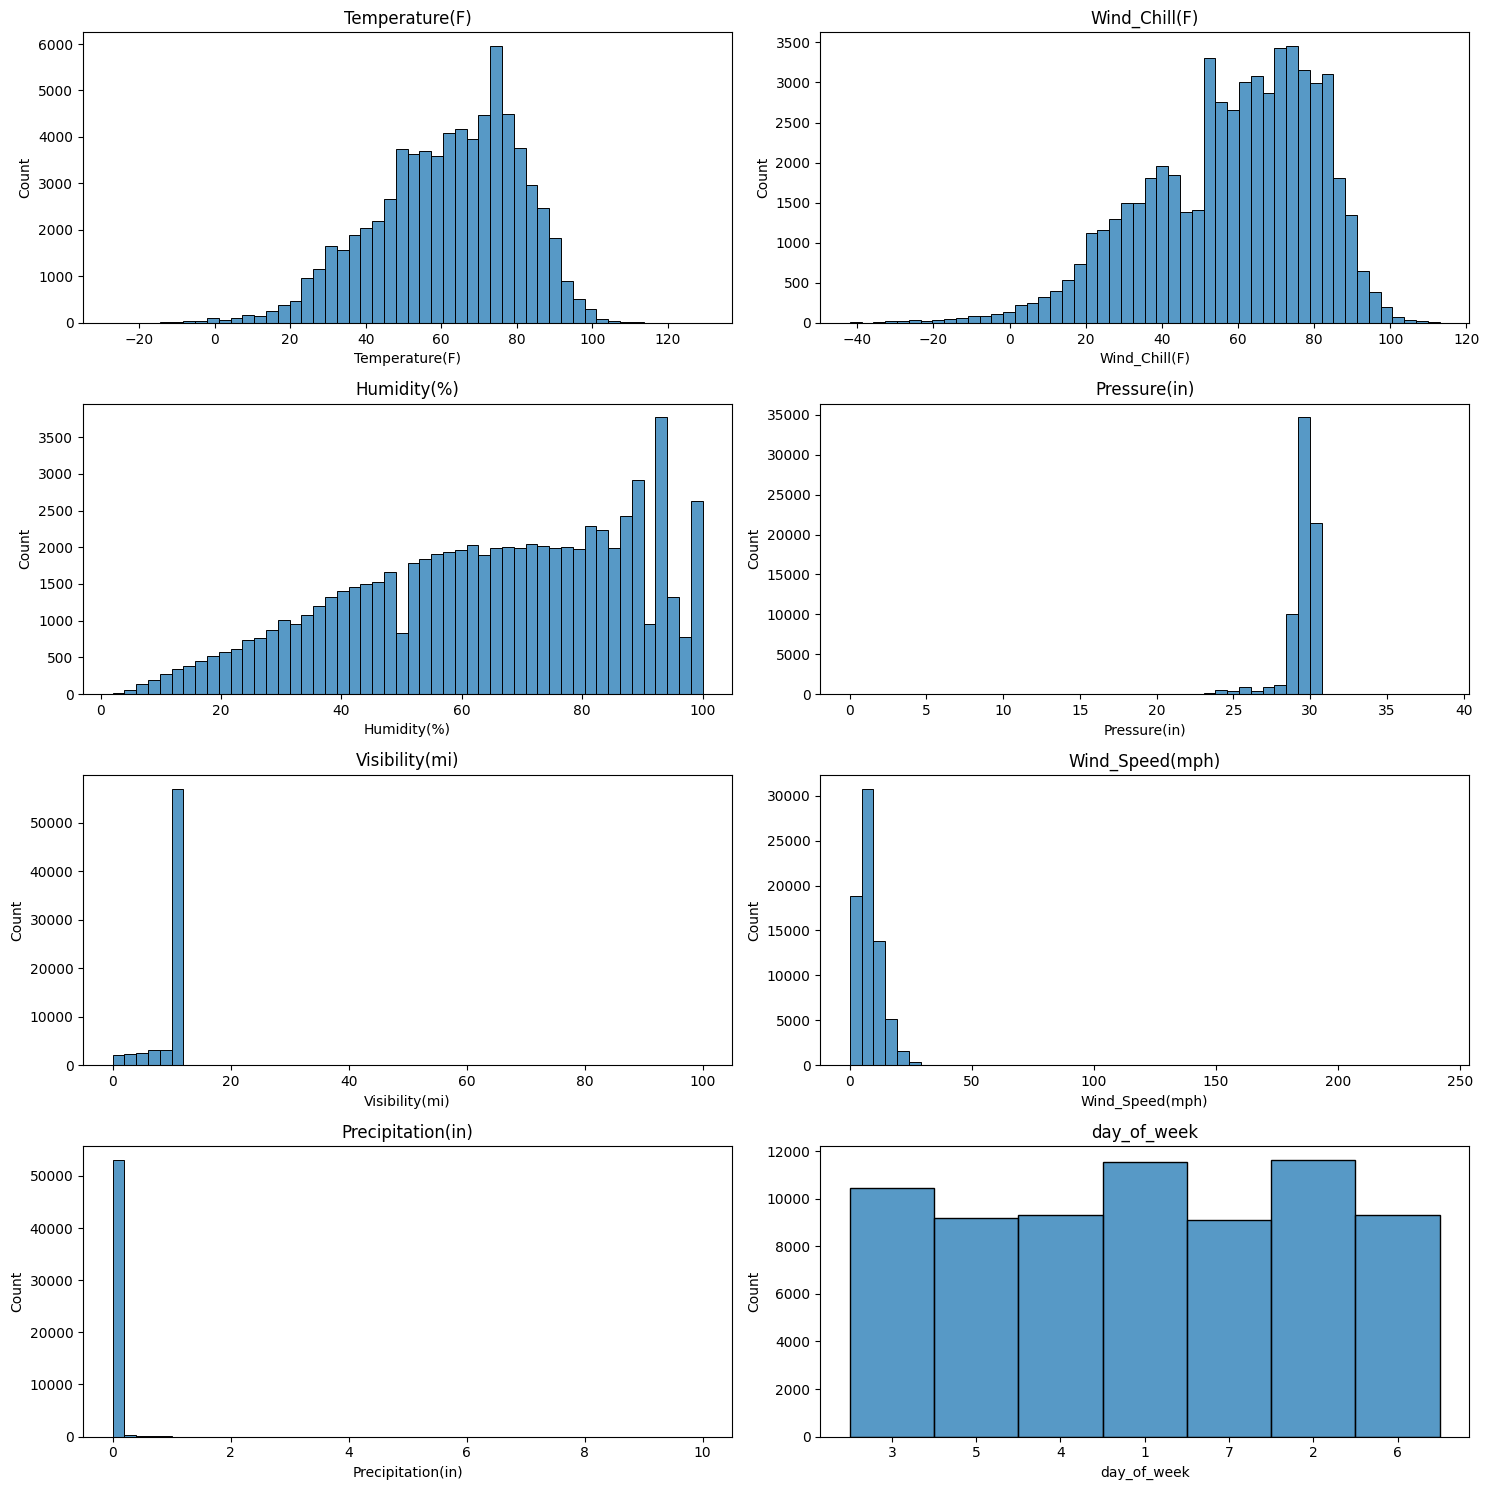

In [79]:
columns_features = ['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)', 'day_of_week']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 4, n_cols = 2, plot = sns.histplot, plot_kwargs={'bins':50}, loop_feature = 'x' ,label=False)

#### Variáveis Binárias

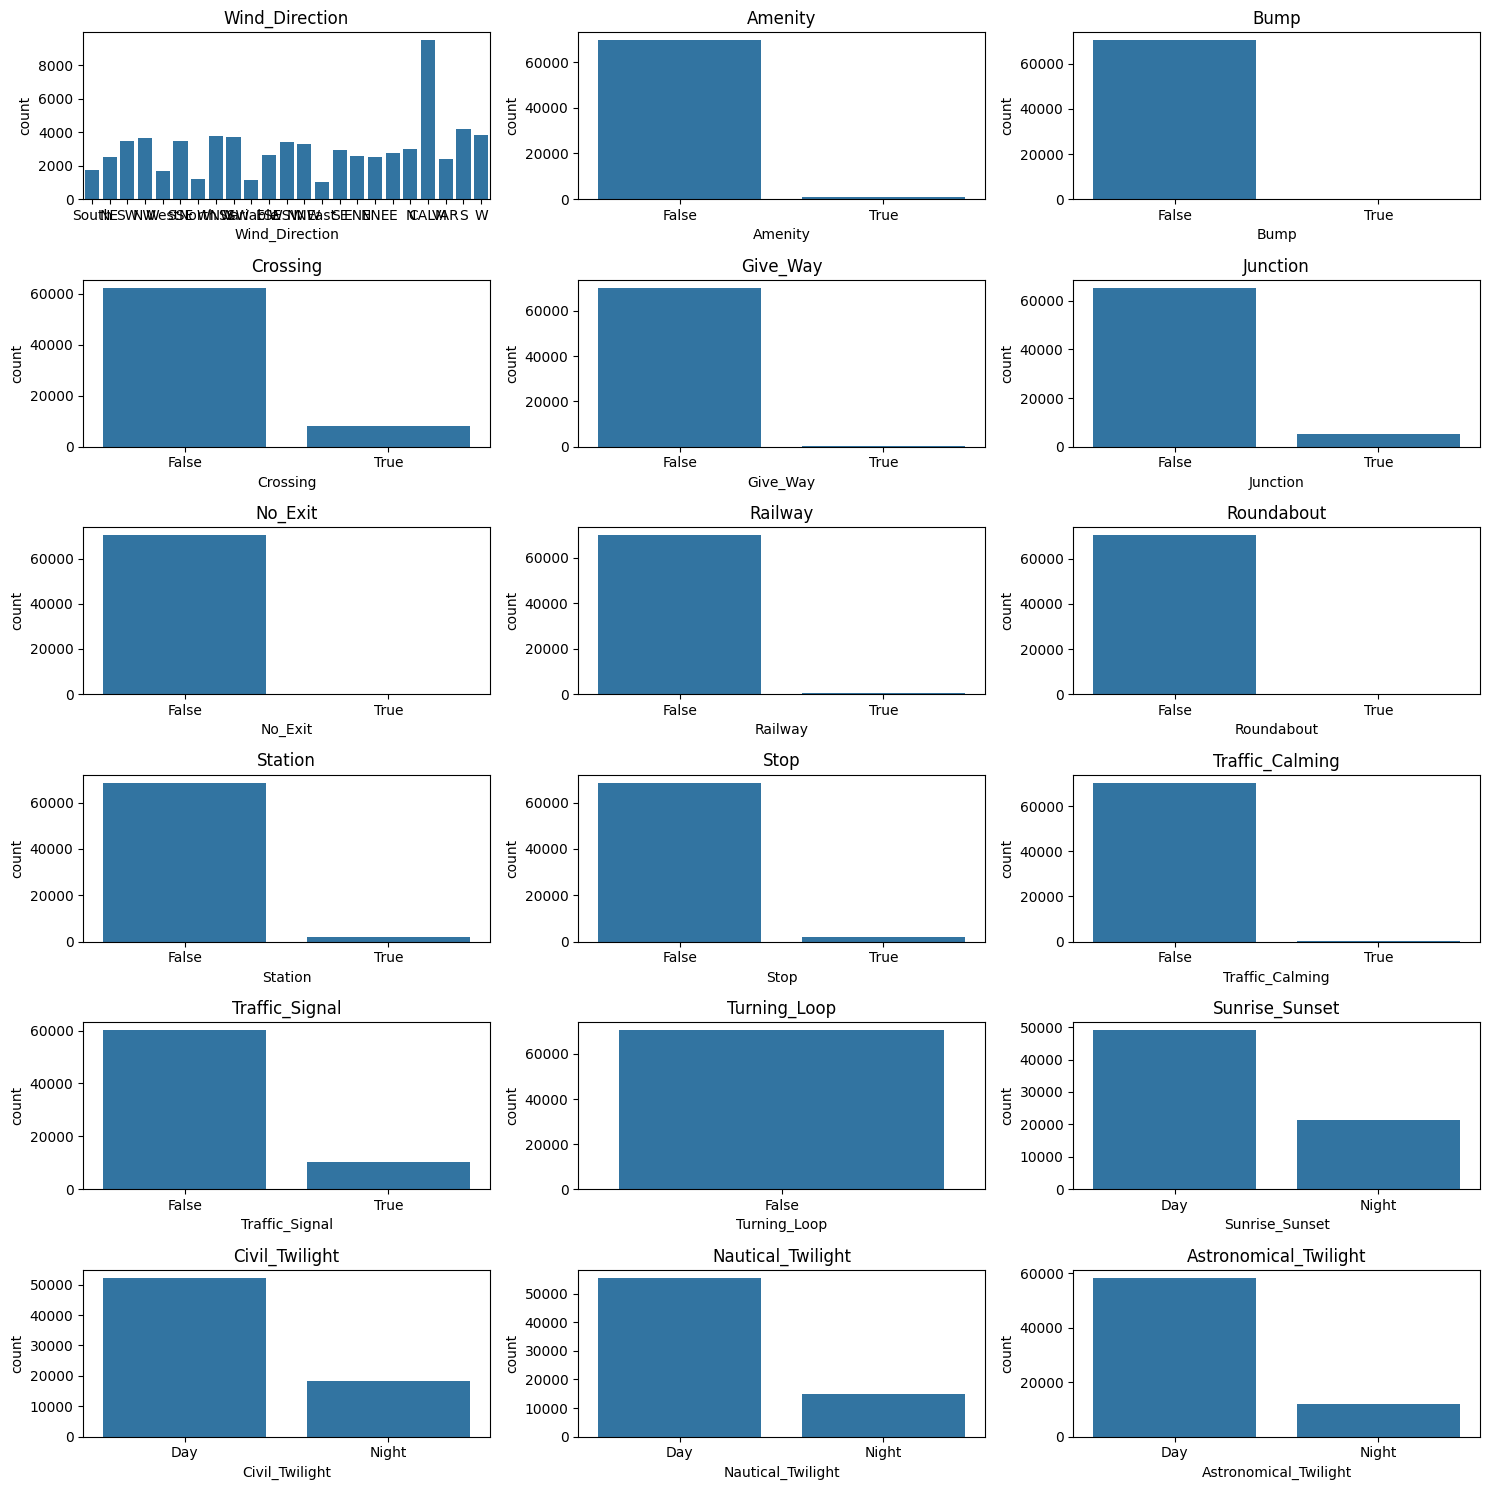

In [70]:
columns_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station', 'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 6, n_cols = 3, plot = sns.countplot, loop_feature = 'x' ,label=False)

#### Variáveis Categoricas

### Análise Bivariada

#### Variáveis Numéricas

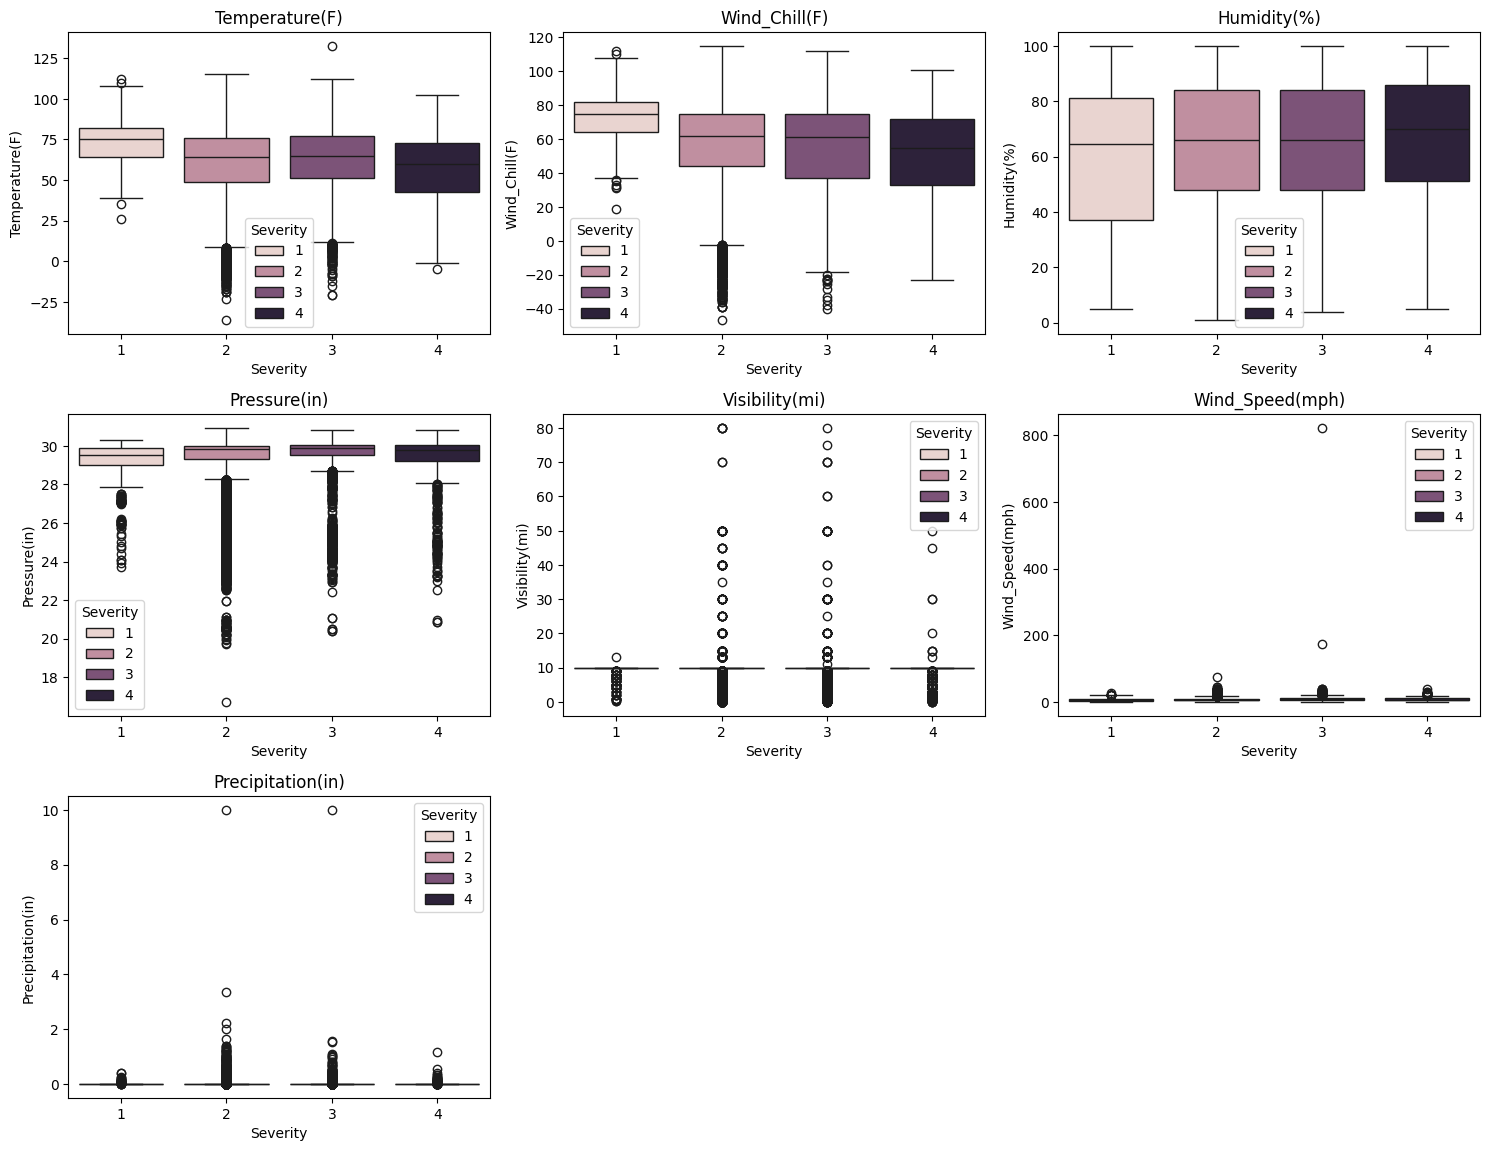

In [74]:
columns_features = ['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 4, n_cols = 3, plot = sns.boxplot, plot_kwargs={'x': 'Severity', 'hue':'Severity'}, loop_feature = 'y' ,label=False)

#### Variáveis Binárias

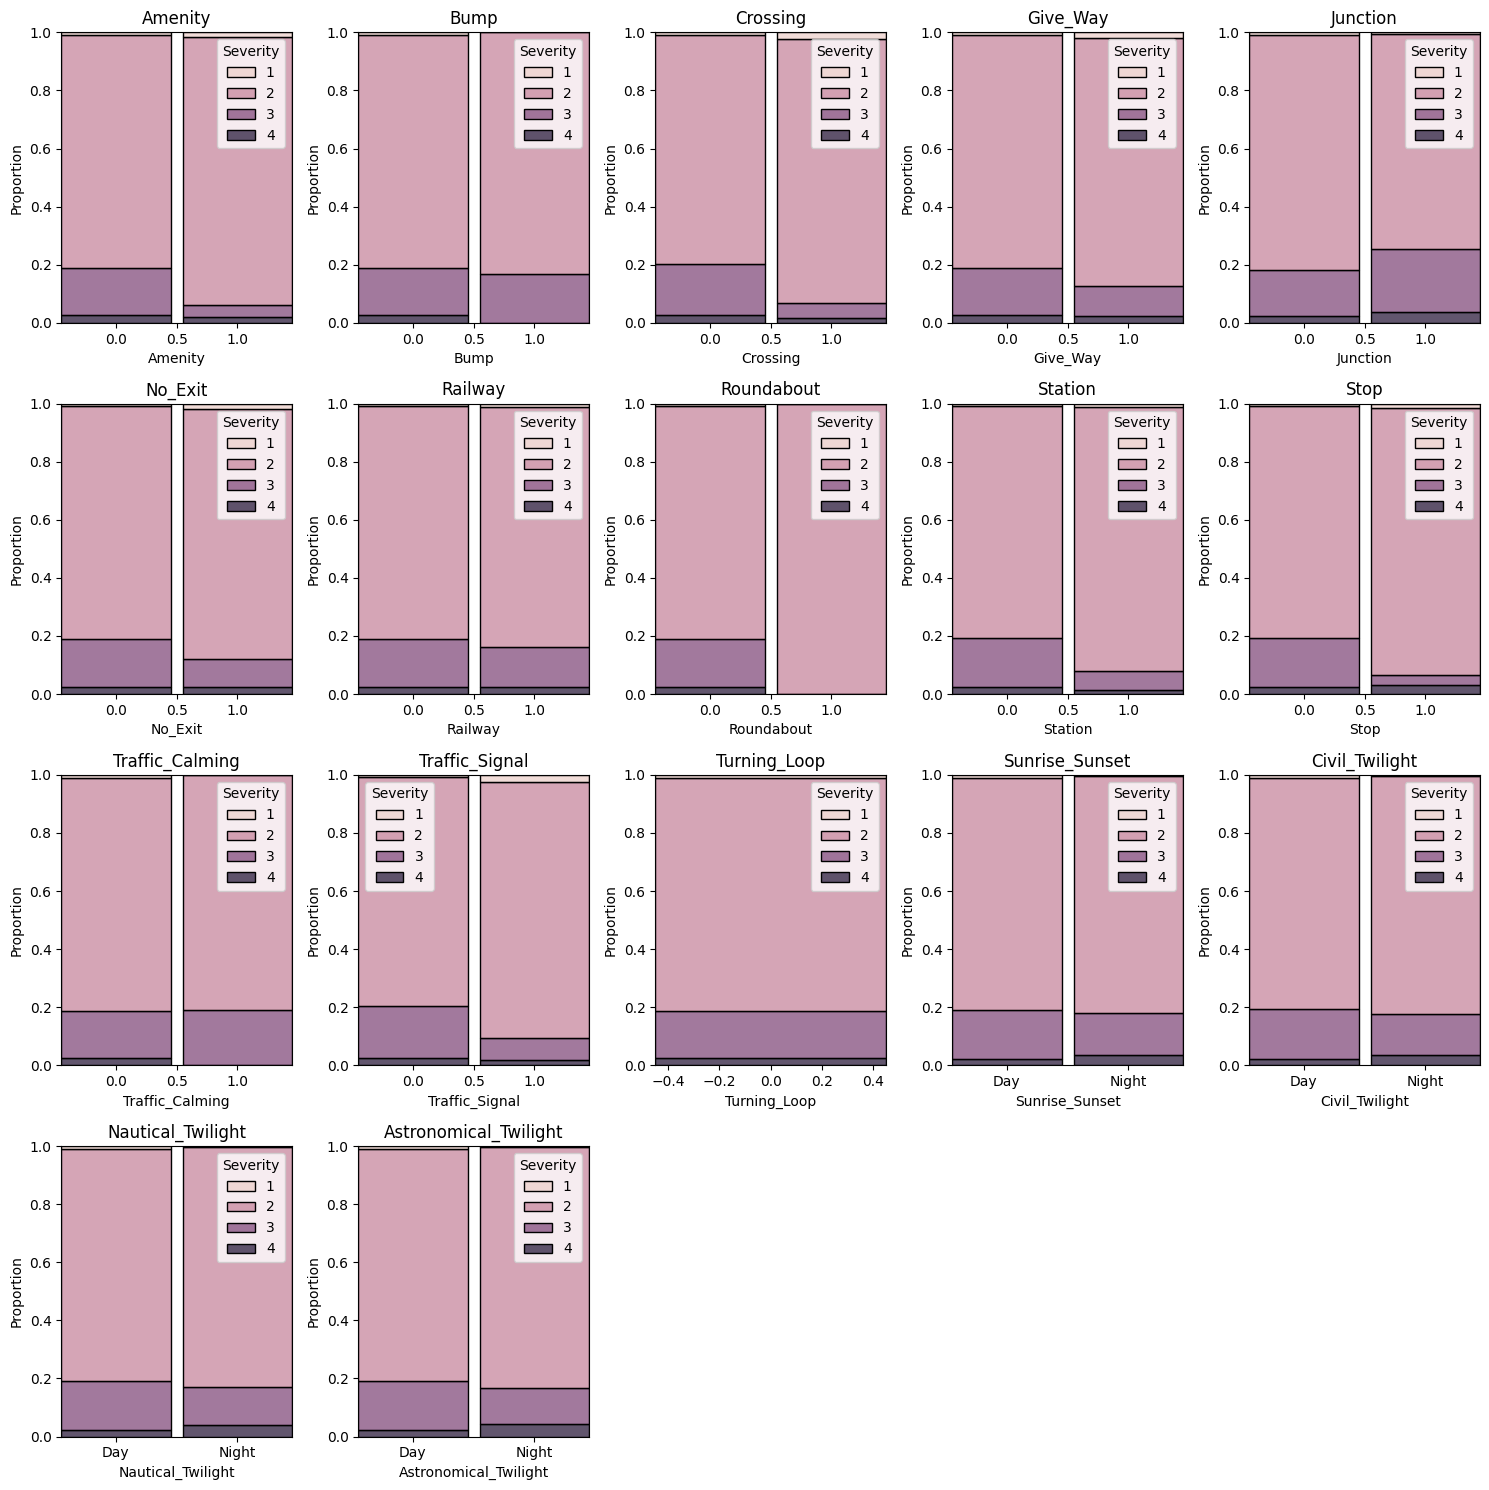

In [65]:
columns_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station', 'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 4, n_cols = 5, plot = sns.histplot, plot_kwargs={'hue':'Severity', 'multiple':'fill','stat':'proportion', 'discrete':True, 'shrink':0.9}, loop_feature = 'x' ,label=False)

In [24]:
potencial_columns = [
'ID',
 'Severity',
 'Start_Time',
 'End_Time',
 'Zipcode',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight'
 ]

## Separação do Treino e Teste

In [ ]:
df_cleaned_subset

In [116]:
# Define as proporções para treino e teste
train_ratio = 0.7
test_ratio = 0.3

# Divide o dataset em treino e teste
train_data, test_data = df_cleaned_subset.randomSplit([train_ratio, test_ratio], seed=42)

In [81]:
train_data.count()

4936373

## Preparar os Dados de Treino
- Transformar as categorias 
- Padronizar, normalizar e etc

In [117]:
selected_features = [
#  'ID',
#  'Severity',
 'Temperature(F)',
#  'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
#  'Wind_Direction',
 'Wind_Speed(mph)',
#  'Precipitation(in)',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight',
 'day_of_week',
 'hour_of_day'
 ]

In [118]:
bool_columns_to_transform = [ 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop']

for column in bool_columns_to_transform:
    train_data = train_data.withColumn(
      column, col(column).cast("int")
    )

cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:

    train_data = train_data.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

train_data = train_data.withColumn(
    'day_of_week', col('day_of_week').cast("int")
)

In [119]:
train_data.select(*selected_features).show()

+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|          37.4|      100.0|       29.62|           3.0|            4.6|      0|   0|       0|       0|       0|      0|      0

## Preparar os Dados de Teste

In [120]:
bool_columns_to_transform = [ 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop']

for column in bool_columns_to_transform:
    test_data = test_data.withColumn(
      column, col(column).cast("int")
    )

cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:

    test_data = test_data.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

test_data = test_data.withColumn(
    'day_of_week', col('day_of_week').cast("int")
)

In [121]:
test_data.select(*selected_features).show()

+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|          77.0|       34.0|       30.02|          10.0|            3.5|      0|   0|       0|       0|       0|      0|      0

## Testar os Modelos

- SVM
- KNN
- Random Forest 

In [123]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

assembler = VectorAssembler(inputCols=selected_features, outputCol="caracteristicas")
train_data = assembler.transform(train_data)

assembler = VectorAssembler(inputCols=selected_features, outputCol="caracteristicas")
test_data = assembler.transform(test_data)

svm = LinearSVC(featuresCol="caracteristicas", labelCol="Severity", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)
predictions = svm_model.transform(test_data)
predictions.select("caracteristicas", "Severity", "prediction").show()

25/01/23 21:24:25 ERROR Executor: Exception in task 7.0 in stage 37.0 (TID 229)]
java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 3.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.Ab

Py4JJavaError: An error occurred while calling o1283.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 37.0 failed 1 times, most recent failure: Lost task 7.0 in stage 37.0 (TID 229) (192.168.18.27 executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 3.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LinearSVC.$anonfun$train$1(LinearSVC.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:172)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:77)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 3.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


## Avaliar Modelo
- Cross Validation

## Avaliar o melhor modelo